<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла</a></span><ul class="toc-item"></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Проверка-статистических-гипотез" data-toc-modified-id="Проверка-статистических-гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка статистических гипотез</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li>

## Определение перспективного тарифа для компании

Необходимо проанализировать тарифы на небольшой выборке клиентов. Определить, какой из тарифов наиболее прибыльный при помощи проверки статистических гипотез.

# Изучение данных из файла

## Описание данных

Таблица `users` :
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

Таблица `calls` :
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` :
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` :
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Таблица `tariffs` :
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Импортируем необходимые для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set()

## Обзор данных

Скачаем таблицы:

In [2]:
users_data = pd.read_csv("datasets/users.csv")
calls_data = pd.read_csv("datasets/calls.csv")
messages_data = pd.read_csv("datasets/messages.csv")
internet_data = pd.read_csv("datasets/internet.csv")
tariffs_data = pd.read_csv("datasets/tariffs.csv")

Рассмотрим общую информацию о каждой из таблиц:

In [3]:
users_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В столбце `chrum_date` есть пропуски, однако, как указано в описании к данным, это означает, что пользователь все ещё пользовался тарифом на момент выгрузки данных. Модно сделать вывод, что пропущенных значений нет. Следует изменить тип данных столбцов `chrun_date` и `reg_date` на datetime для удобства. Значения столбца `tariff` можно изменить на категориальный.

Рассмотрим данные на наличие аномалий:

In [5]:
users_data.duplicated().sum()

0

Явных дубликатов в данных нет.

Узнаем, есть ли аномальные значения возраста:

In [6]:
users_data["age"].sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

Аномальных значений нет.

Исследуем столбцы `city`, `tariff` на наличие неявных дубликатов:

In [7]:
users_data["city"].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [8]:
users_data["tariff"].unique()

array(['ultra', 'smart'], dtype=object)

Никаких аномалий в таблице `users_data` не выявлено. Можно переходить к рассмотрению следующей таблицы.

In [9]:
calls_data.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [10]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропущенных значений в таблице нет. Тип данных стобца `call_date` следует перевести в datetime.

Рассмотрим таблицу на наличие аномалий:

In [11]:
calls_data.duplicated().sum()

0

Явных дубликатов в таблице нет.

Рассмотрим столбец `duration`:

In [12]:
calls_data["duration"].sort_values().unique()

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 3.647e+01, 3.735e+01,
       3.800e+01])

Можно заметить, что в таблице присутствуют звонки нулевой длительности. Это не является аномалией, поскольку таким образом записываются сброшенные звонки. Максимальное значение продолжительности разговора соответствует 38 минутам, что является вполне реальным значением.

Аномалий в `calls_data` не найдено. Переходим к следующей таблице.

In [13]:
messages_data.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропущенных значений в таблице нет. Тип данных столбца `message_date` следует изменить на datetime.

Исследуем аномалии в таблице:

In [15]:
messages_data.duplicated().sum()

0

Явных дубликатов нет.

Никаких аномалий нет, поэтому можно переходить к следующей таблице.

In [16]:
internet_data.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [17]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Пропусков в данных нет. Тип данных столбца `session_date` следует перевести в datetime. В глаза бросается наличие лишнего столбца `Unnamed: 0`. Он дублирует индекс и появился, скорее всего, из-за какой-то ошибки. При дальнейшей предобработке данных необходимо будет убрать этот столбец.

Рассмотрим данные на наличие аномалий:

In [18]:
internet_data[["id","mb_used", "session_date","user_id"]].duplicated().sum()

0

Дубликатов нет.

Рассмотрим столбце `mb_used` на наличие аномальных значений:

In [19]:
internet_data["mb_used"].sort_values().unique()

array([0.00000e+00, 3.00000e-02, 4.00000e-02, ..., 1.65155e+03,
       1.70275e+03, 1.72483e+03])

Среди значений присутствуют нулевые. Скорее всего, аналогично нулевым значениям в информации о звонках, они отображают какие-либо неудачные попытки начать сессию. Максимальные значения из этой таблицы также кажутся вполне разумными.

Можно переходить к рассмотрению другой таблицы.

In [20]:
tariffs_data.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица содержит информацию о тарифах и в анализе не нуждается. Данные, указанные в ней корректы.

Таким образои, можно приступать к предобработке данных, в которой необходимо будет заменить типы данных для всех дат, убрать лишний столбец из таблицы `internet_data` и вычислить некоторые полезные для дальнейшего анализа величины.

# Предобработка данных

## Замена типов и удаление лишнего столбца

Заменим тип данных стобцов, содержащих дату, на datetime во всех таблицах:

In [21]:
users_data["churn_date"] = pd.to_datetime(users_data["churn_date"], format = "%Y-%m-%d")
users_data["reg_date"] = pd.to_datetime(users_data["reg_date"], format = "%Y-%m-%d")
calls_data["call_date"] = pd.to_datetime(calls_data["call_date"], format = "%Y-%m-%d")
messages_data["message_date"] = pd.to_datetime(messages_data["message_date"], format = "%Y-%m-%d")
internet_data["session_date"] = pd.to_datetime(internet_data["session_date"], format = "%Y-%m-%d")

Проверим корректность замены на примере данных из таблицы `users_data`:

In [22]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Замена прошла успешно.

Заменим тип данных столбца `tariff` из таблицы `users_data` на категориальный:

In [23]:
users_data["tariff"] = users_data["tariff"].astype("category")

Убедимся, что замена прошла успешно:

In [24]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    category      
dtypes: category(1), datetime64[ns](2), int64(2), object(3)
memory usage: 28.1+ KB


Тип данных столбца tariff действительно поменялся на категориальный.

Удалим лишний столбец `Unnamed: 0` из таблицы `internet_data`:

In [25]:
del(internet_data["Unnamed: 0"])

Проверим результат:

In [26]:
internet_data.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Лишний столбец был удален.

## Преобразование данных

Рассчитаем некоторые параметры, необходимые при дальнейшей проверке статистических гипотез и анализе.

Для начала рассчитаем количество потраченных минут за каждый месяц каждым пользователем. Посмотрим в какой промежуток времени попадают даты из таблиц. Учтем также, что потраченное время всегда округляется в большую сторону до минут.

In [27]:
print(f"от {calls_data['call_date'].min()} до {calls_data['call_date'].max()}")

от 2018-01-01 00:00:00 до 2018-12-31 00:00:00


В таблицах содержится информация только за один 2018 год. Создадим вспомогательную временную тублицу с информацией о номере месяца:

In [28]:
calls_data_with_month = calls_data.copy()
calls_data_with_month["month"] = calls_data["call_date"].apply(lambda x: x.month)
calls_data_with_month["duration"] = calls_data_with_month["duration"].apply(lambda x: math.ceil(x))
calls_data_with_month.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Теперь составим таблицу с информацией о количестве потраченных минут за каждый месяц:

In [29]:
calls_info = calls_data_with_month.pivot_table(index = "user_id", columns = "month", values = "duration", aggfunc = "sum")
calls_info.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0


Удалим временную таблицу:

In [30]:
del(calls_data_with_month)

Проделаем аналогичную процедуру для нахождения количество смс, отправленных каждым пользователем в течении месяца:

In [31]:
messages_data_with_month = messages_data.copy()
messages_data_with_month["month"] = messages_data_with_month["message_date"].apply(lambda x: x.month)
messages_data_with_month.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [32]:
messages_info = messages_data_with_month.pivot_table(index = "user_id", columns = "month", values = "id", aggfunc = "count")
messages_info.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0


In [33]:
del(messages_data_with_month)

Создание таблицы прошло успешно, теперь необходимо поссчитать объём интернета, потраченный каждым из пользователей. Учтем, что в конце месяца потраченный интернет округляется до целого числа гигабайтов.

In [34]:
internet_data_with_month = internet_data.copy()
internet_data_with_month["month"] = internet_data_with_month["session_date"].apply(lambda x: x.month)
internet_data_with_month["gb_used"] = internet_data_with_month["mb_used"].apply(lambda x: x/1024)
internet_data_with_month.head()

,id,mb_used,session_date,user_id,month,gb_used
0,1000_0,112.95,2018-11-25,1000,11,0.110303
1,1000_1,1052.81,2018-09-07,1000,9,1.028135
2,1000_2,1197.26,2018-06-25,1000,6,1.169199
3,1000_3,550.27,2018-08-22,1000,8,0.537373
4,1000_4,302.56,2018-09-24,1000,9,0.295469


In [35]:
internet_info = internet_data_with_month.pivot_table(index = "user_id", columns = "month", values = "gb_used", aggfunc = "sum")
internet_info = internet_info.applymap(lambda x: math.ceil(x) if not(np.isnan(x)) else x)
internet_info.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,3.0,23.0,14.0,14.0,15.0,15.0,15.0,10.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,14.0
1002,NaN,NaN,NaN,NaN,NaN,11.0,18.0,20.0,17.0,14.0,19.0,18.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,13.0,15.0,12.0,10.0
1004,NaN,NaN,NaN,NaN,14.0,18.0,22.0,28.0,15.0,19.0,16.0,18.0


Теперь рассчитаем общую прибыль за каждый месяц от каждого пользователя, учитывая его тарифный план. Перед этим добавим в каждую из таблиц `info` информацию о тарияном плане пользователя:

In [36]:
internet_info["tariff"] = internet_info.index.map(lambda x: users_data.query("user_id == @x")["tariff"].to_numpy()[0])
messages_info["tariff"] = messages_info.index.map(lambda x: users_data.query("user_id == @x")["tariff"].to_numpy()[0])
calls_info["tariff"] = calls_info.index.map(lambda x: users_data.query("user_id == @x")["tariff"].to_numpy()[0])

Проверим результат:

In [37]:
internet_info.head()

month,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,3.0,23.0,14.0,14.0,15.0,15.0,15.0,10.0,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,14.0,smart
1002,NaN,NaN,NaN,NaN,NaN,11.0,18.0,20.0,17.0,14.0,19.0,18.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,13.0,15.0,12.0,10.0,ultra
1004,NaN,NaN,NaN,NaN,14.0,18.0,22.0,28.0,15.0,19.0,16.0,18.0,ultra


In [38]:
messages_info.head()

month,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,ultra
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,ultra
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,ultra
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,smart


In [39]:
calls_info.head()

month,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,smart
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,ultra
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,ultra


Добавление новых столбцов прошло успешно, теперь приступим к рассчету прибыли, для этого напишем специальные функции. Затем применим их к каждой таблице, чтобы узнать цену дополнительно потраченных минут, интернета или сообщений. Сложив значения этих трех таблиц, учитывая базовую стоимость тарифа, получим искомую информацию:

In [41]:
def minutes_income_counter(row):
    name = row.iloc[-1]
    extra_price = int(tariffs_data.query("tariff_name == @name")["rub_per_minute"])
    included = int(tariffs_data.query("tariff_name == @name")["minutes_included"])
    row[:-1] = (row[:-1] - included).map(lambda x: 0 if x < 0 else x) * extra_price
    return row

def messages_income_counter(row):
    name = row.iloc[-1]
    extra_price = int(tariffs_data.query("tariff_name == @name")["rub_per_message"])
    included = int(tariffs_data.query("tariff_name == @name")["messages_included"])
    row[:-1] = (row[:-1] - included).map(lambda x: 0 if x < 0 else x) * extra_price
    return row

def internet_income_counter(row):
    name = row.iloc[-1]
    extra_price = int(tariffs_data.query("tariff_name == @name")["rub_per_gb"])
    included = int(tariffs_data.query("tariff_name == @name")["mb_per_month_included"])
    row[:-1] = (row[:-1] - included).map(lambda x: 0 if x < 0 else x) * extra_price
    return row
    

Применим эти функции к таблицам:

In [42]:
calls_income = calls_info.apply(minutes_income_counter, axis = 1)
messages_income = messages_info.apply(messages_income_counter, axis = 1)
internet_income = internet_info.apply(internet_income_counter, axis = 1)

Подготовим таблицу, в которую занесем итоговую сумму, потраченную пользователем в каждом месяце

In [43]:
total_income = pd.DataFrame(index = range(1000,1500), columns = np.arange(1,13).astype("str"))
total_income = total_income.fillna(0)
total_income["total"] = total_income["1"]
total_income["tariff"] = total_income.index.map(lambda x: users_data.query("user_id == @x")["tariff"].to_numpy()[0])
total_income.head()

,1,2,3,4,5,6,7,8,9,10,11,12,total,tariff
1000,0,0,0,0,0,0,0,0,0,0,0,0,0,ultra
1001,0,0,0,0,0,0,0,0,0,0,0,0,0,smart
1002,0,0,0,0,0,0,0,0,0,0,0,0,0,smart
1003,0,0,0,0,0,0,0,0,0,0,0,0,0,ultra
1004,0,0,0,0,0,0,0,0,0,0,0,0,0,ultra


Прибавим к ней таблицы с прибылью:

In [44]:
total_income.loc[calls_income.index, :"12"] =  total_income.loc[calls_income.index, :"12"].to_numpy() + calls_income.loc[:,:12].to_numpy()
total_income.loc[messages_income.index, :"12"] =  total_income.loc[messages_income.index, :"12"].to_numpy() + messages_income.loc[:,:12].to_numpy()
total_income.loc[internet_income.index, :"12"] =  total_income.loc[internet_income.index, :"12"].to_numpy() + internet_income.loc[:,:12].to_numpy()

Проыерим результат (Поскольку у первых строк нет затрат на дополнительные минуты, гигабайты или сообщения, рассмотрим последние строки таблицы):

In [45]:
total_income.tail()

,1,2,3,4,5,6,7,8,9,10,11,12,total,tariff
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,ultra
1496,0.0,282.0,171.0,63.0,0.0,165.0,246.0,81.0,0.0,0.0,486.0,57.0,0,smart
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,135.0,0,smart
1498,NaN,NaN,NaN,NaN,NaN,NaN,0.0,36.0,0.0,0.0,NaN,NaN,0,smart
1499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,363.0,48.0,0,smart


Теперь добавим базовую стоимость тарифа ко всем этим значениям:

In [46]:
total_income.loc[total_income.loc[:, "tariff"] == "ultra", :"12"] += tariffs_data.loc[1, "rub_monthly_fee"]
total_income.loc[total_income.loc[:, "tariff"] == "smart", :"12"] += tariffs_data.loc[0, "rub_monthly_fee"]

In [47]:
total_income.tail()

,1,2,3,4,5,6,7,8,9,10,11,12,total,tariff
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,0,ultra
1496,550.0,832.0,721.0,613.0,550.0,715.0,796.0,631.0,550.0,550.0,1036.0,607.0,0,smart
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.0,550.0,685.0,0,smart
1498,NaN,NaN,NaN,NaN,NaN,NaN,550.0,586.0,550.0,550.0,NaN,NaN,0,smart
1499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.0,550.0,913.0,598.0,0,smart


Все выполнилось корректно. Теперь посчитаем общую прибыль за все месяцы (столбце `total`) и заменим пропущенные занчения нулями для более удобного восприятия:

In [48]:
total_income["total"] = total_income.loc[:,:"12"].sum(axis = 1)
total_income = total_income.fillna(0)
total_income.tail()

,1,2,3,4,5,6,7,8,9,10,11,12,total,tariff
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,9750.0,ultra
1496,550.0,832.0,721.0,613.0,550.0,715.0,796.0,631.0,550.0,550.0,1036.0,607.0,8151.0,smart
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,685.0,1785.0,smart
1498,0.0,0.0,0.0,0.0,0.0,0.0,550.0,586.0,550.0,550.0,0.0,0.0,2236.0,smart
1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,913.0,598.0,2611.0,smart


На этом преобразования данных закончены. Можно переходить к их исследованию.

# Исследовательский анализ данных

Проанализируем поведение клиентов, основываясь на выборке, перед проверкой статистических гипотез.

Поссчитаем количесвто минут, которое в среднем требуется ползьзователям различных тарифов в месяц. Для этого воспользуемся таблицей `calls_info`.

Реализуем функцию для подсчета среднего:

In [49]:
def count_mean(row):
    row = row.dropna()
    row_mean = np.mean(row)
    return row_mean

In [50]:
calls_info_ultra = calls_info.query("tariff == 'ultra'")
vals_ultra = np.array(calls_info_ultra.iloc[:,:12].apply(count_mean, axis = 1))

Рассчитаем среднее и стандартное отклонение для данной выборки:

In [51]:
print(f"Среднее: {np.mean(vals_ultra)}, стандартное отклонение: {np.std(vals_ultra)}")

Среднее: 546.6854415786235, стандартное отклонение: 267.3984713544133


Среднее количество минут, которое в месяц тратят пользователи тарифа ultra гораздо менньше включенного в пакет тарифа минут. При этом стандартное отклонение у этих данных довольно большое (примерно половина от величины среднего). Рассмотрим пользователей тарифа smart.

In [52]:
calls_info_smart = calls_info.query("tariff == 'smart'")
vals_smart = np.array(calls_info_smart.iloc[:,:12].apply(count_mean, axis = 1))
print(f"Среднее: {np.mean(vals_smart)}, стандартное отклонение: {np.std(vals_smart)}")

Среднее: 420.8401470703762, стандартное отклонение: 143.26800944209174


Для пользователей тарифа smart срелнее количество минт также меньше включенного в тариф, однако ближе к нему. Стандартное отклонение у этих данных большое. Визуализируем количество минут, которое тратят пользователи разных тарифов при помощи гистограммы.

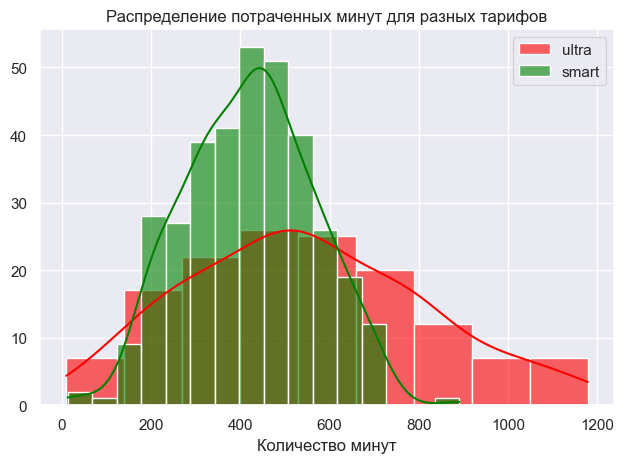

In [53]:
fix, ax = plt.subplots(layout = "tight")

sns.histplot(x = vals_ultra, alpha = 0.6, color = "red", label = "ultra", kde = True, ax = ax )
sns.histplot(x = vals_smart, alpha = 0.6, color = "green", label = "smart", kde = True, ax = ax )

ax.legend()
ax.xaxis.set_label_text("Количество минут")
ax.yaxis.set_label_text("")
ax.set_title("Распределение потраченных минут для разных тарифов")

pass

Посмотрим на диаграмму размаха для этих величин:

Медиана: 525.5, среднее: 546.6854415786235


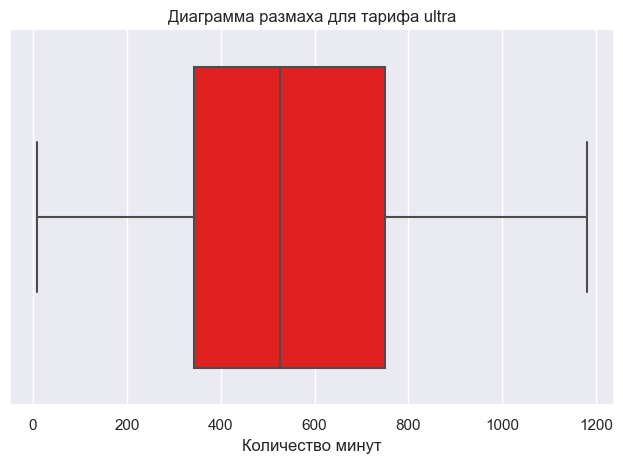

In [54]:
fix, ax = plt.subplots(layout = "tight")

sns.boxplot(x = vals_ultra, color = "red")

ax.xaxis.set_label_text("Количество минут")
ax.yaxis.set_label_text("")
ax.set_title("Диаграмма размаха для тарифа ultra")

print(f"Медиана: {np.median(vals_ultra)}, среднее: {np.mean(vals_ultra)}")

Медиана: 425.25, среднее: 420.8401470703762


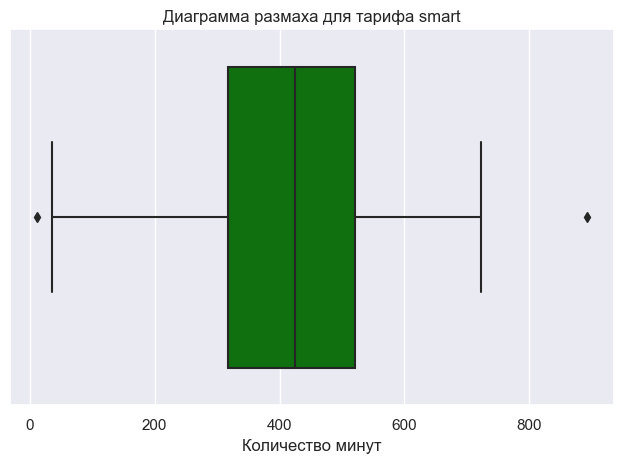

In [55]:
fix, ax = plt.subplots(layout = "tight")

sns.boxplot(x = vals_smart, color = "green")

ax.xaxis.set_label_text("Количество минут")
ax.yaxis.set_label_text("")
ax.set_title("Диаграмма размаха для тарифа smart")

print(f"Медиана: {np.median(vals_smart)}, среднее: {np.mean(vals_smart)}")

Оба распределения напоминают нормальное. Поскольку стандартное отклонение для тарифа ultra намного больше, чем для тарифа smart, размах красной гистограммы больше. Также, исходя из диаграмм размаха и данных о медиане и среднем, можно сделать вывод, что распределение для тарифа smart почти не скошено, в то время как распределение для тарифа ultra немного скошено вправо.

Проведем аналогичное рассмотрение для количества сообщений за месяц:

In [56]:
messages_info_ultra = messages_info.query("tariff == 'ultra'")
vals_ultra = np.array(messages_info_ultra.iloc[:,:12].apply(count_mean, axis = 1))
print(f"Среднее: {np.mean(vals_ultra)}, стандартное отклонение: {np.std(vals_ultra)}")

Среднее: 64.55580197132616, стандартное отклонение: 43.21529576877414


Среднее количество отправленных смс, как и в случае с минутами, сильно ниже доступного лимита. Стандартное отклонение данной величины крайне большое. Скорее всего, множество пользователей предпочитают месенджеры и почти не отправляют смс, а другие наоборот.

In [57]:
messages_info_smart = messages_info.query("tariff == 'smart'")
vals_smart = np.array(messages_info_smart.iloc[:,:12].apply(count_mean, axis = 1))
print(f"Среднее: {np.mean(vals_smart)}, стандартное отклонение: {np.std(vals_smart)}")

Среднее: 37.57560563057251, стандартное отклонение: 24.80856229517905


Среднее значение ниже лимита, но доволно близко к нему. Стандартное отклонение, как и в тарифе ultra, велико. Построим гистограммы для взуализации данных.

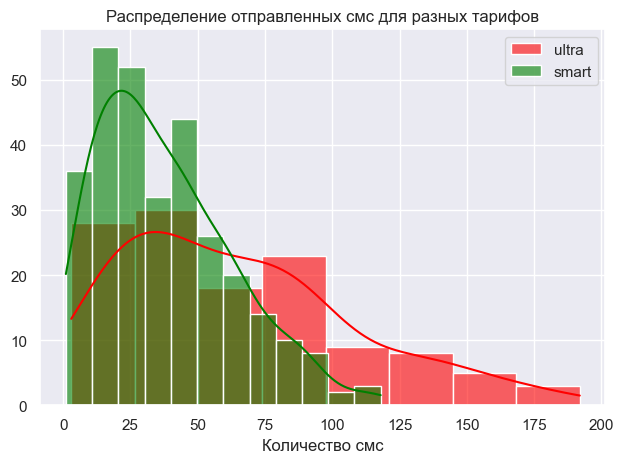

In [58]:
fix, ax = plt.subplots(layout = "tight")

sns.histplot(x = vals_ultra, alpha = 0.6, color = "red", label = "ultra", kde = True )
sns.histplot(x = vals_smart, alpha = 0.6, color = "green", label = "smart", kde = True )

ax.legend()
ax.xaxis.set_label_text("Количество смс")
ax.yaxis.set_label_text("")
ax.set_title("Распределение отправленных смс для разных тарифов")

pass

Распределения для смс больше напоминают распределение Пуассона. Видно, что большинство пользователей предпочитает не пользоваться смс.

Рассмотрим данные о количестве интернета, используемого в месяц:

In [59]:
internet_info_ultra = internet_info.query("tariff == 'ultra'")
vals_ultra = np.array(internet_info_ultra.iloc[:,:12].apply(count_mean, axis = 1))
print(f"Среднее: {np.mean(vals_ultra)}, стандартное отклонение: {np.std(vals_ultra)}")

Среднее: 19.74082368878287, стандартное отклонение: 7.94342530180589


Среднее количество потраченныг гигабайт меньше лимита, но гораздно ближе к нему в сравнении с минутами и смс. Стандартное отконение для гигабайт также велико.

In [60]:
internet_info_smart = internet_info.query("tariff == 'smart'")
vals_smart = np.array(internet_info_smart.iloc[:,:12].apply(count_mean, axis = 1))
print(f"Среднее: {np.mean(vals_smart)}, стандартное отклонение: {np.std(vals_smart)}")

Среднее: 16.318233147804577, стандартное отклонение: 3.4938205292239037


Количество потраченных гигабайт в среднем больше, чем лимит. При этом стандартное отклонение меньше, чем для других величин (пятая часть, а не половина или треть). Это можно объяснить тем, что пользователи, превысившие лимит стараются тратить меньше интернета, чтобы не заплатить много денег за дополнительный интернет. Рассмотрим распределение для гигабайт.

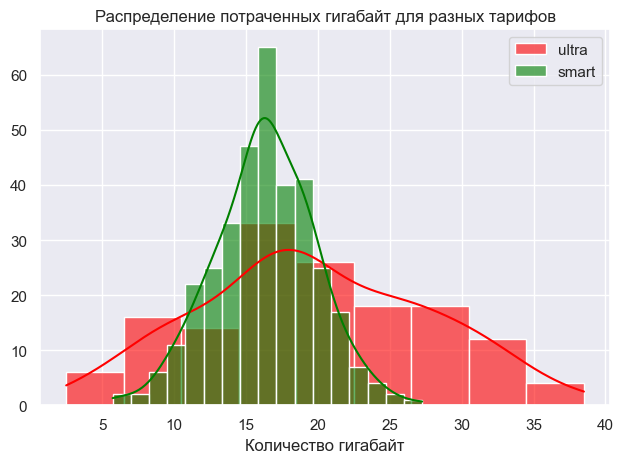

In [61]:
fix, ax = plt.subplots(layout = "tight")

sns.histplot(x = vals_ultra, alpha = 0.6, color = "red", label = "ultra", kde = True )
sns.histplot(x = vals_smart, alpha = 0.6, color = "green", label = "smart", kde = True )

ax.legend()
ax.xaxis.set_label_text("Количество гигабайт")
ax.yaxis.set_label_text("")
ax.set_title("Распределение потраченных гигабайт для разных тарифов")

pass

Рассмотрим диаграмму размаха:

Медиана: 18.8, среднее: 19.74082368878287


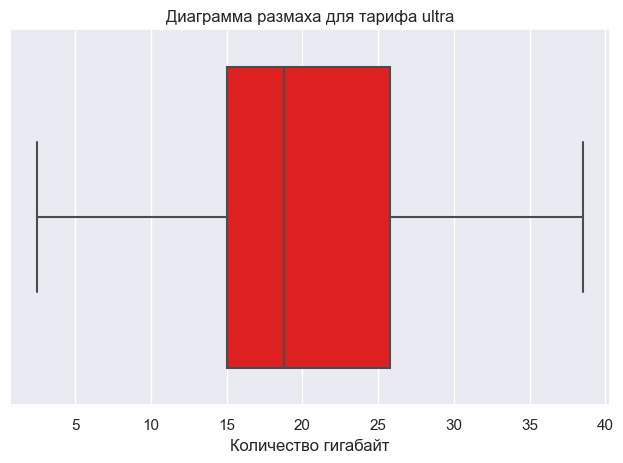

In [62]:
fix, ax = plt.subplots(layout = "tight")

sns.boxplot(x = vals_ultra, color = "red")

ax.xaxis.set_label_text("Количество гигабайт")
ax.yaxis.set_label_text("")
ax.set_title("Диаграмма размаха для тарифа ultra")

print(f"Медиана: {np.median(vals_ultra)}, среднее: {np.mean(vals_ultra)}")

Медиана: 16.333333333333332, среднее: 16.318233147804577


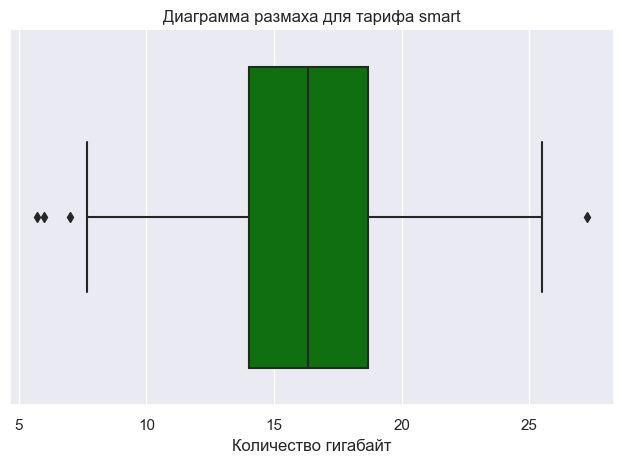

In [63]:
fix, ax = plt.subplots(layout = "tight")

sns.boxplot(x = vals_smart, color = "green")

ax.xaxis.set_label_text("Количество гигабайт")
ax.yaxis.set_label_text("")
ax.set_title("Диаграмма размаха для тарифа smart")

print(f"Медиана: {np.median(vals_smart)}, среднее: {np.mean(vals_smart)}")

Распределения напоминают нормальное распределение. Как и в случае минут, распределение тарифа smart не скошено, в то время как распределение тарифа ultra скошено вправо.

Можно сделать вывод, что пользователи тарифа ultra не тратят столько минут и смс, сколько доступно в тарифе. Пользователи тарифа smart, наоборот, часто превышают лимит по смс, минутам и, в особенности, интернету. Исходя из анализа можно сделать выводы, что самая нужная пользователем услуга - интернет. Это логично, потому что он может заенить собой как звонки, так и сообщения. Также пользователи почти не пользуются смс. В обоих тарифах максимумы распределений находятся близко к маленьким значениям. Можно заметить, что для тарифа ultra распределение всегда скошено вправо. Распределения для тарифа smart не скошены.

Перейдем к проверке статистических гипотез.

# Проверка статистических гипотез

## Гипотеза 1

Проверим, отличается ли средняя прибыль от пользователей с разными тарифами или нет. Сформулируем нулевую гипотезу: средняя прибыль не отличается. Альетрнатвная гипотеза в данном случае: средняя прибыль отличается. Пока не известно приносит ли больше тариф ulta за счет высокой цены или тариф smart за счет покупки дополнительных минут и интернета, поэтому проведем двухсторонний тест. Волспользуемся t-тестом, чтобы проверить эту гипотезу. Перед этим посмотрим, одинаковые ли дисперсии у двух групп пользователей:

In [64]:
std_smart = np.std(total_income.query("tariff == 'smart'")["total"])
std_ultra = np.std(total_income.query("tariff == 'ultra'")["total"])
print(f"тариф smart: {std_smart:.2f}, тариф ultra: {std_ultra:.2f}")

тариф smart: 2581.85, тариф ultra: 6337.58


Дисперсии отличаеются довольно, существенно, укажем это при проведении теста. Уровень значимости возьмем равным одному проценту.

In [65]:
alpha = 0.01

_, p_value = stats.ttest_ind(total_income.query("tariff == 'smart'")["total"],total_income.query("tariff == 'ultra'")["total"],equal_var = False)


if p_value < alpha:
    if np.mean(total_income.query("tariff == 'smart'")["total"]) > np.mean(total_income.query("tariff == 'ultra'")["total"]):
        print("Нулевая гипотеза отвергнута, тариф smart приносит больше денег")
    else:
        print("Нулевая гипотеза отвергнута, тариф ultra приносит больше денег")
else:    
    print("Не получилось отвергнуть нулевую гипотезу")


Нулевая гипотеза отвергнута, тариф ultra приносит больше денег


Нулевая гипотеза была отвегрнута, не смотря на то, что пользователи тарифа smart чаще докупают минуты и особенно гигабайты, более прибыльным оказался тариф ultra.

## Гипотеза 2

Проверим, является ли прибыль, полученная от московских пользователей больше, чем от жителей других городов. Нулевая гипотеза: Прибыль от московских и не московских пользователей одинакова. Альтернативная гипотеза: Мосеовские пользователи приносят больше прибыли. Как и в первом случае, будем использовать t-тест. Уровень значимости возьмём один процент. В данном случае надо будет воспользоваться уже односторонним, а не двусторонним тестом. Перед этим дополним таблицу `total_income`.

In [67]:
total_income = total_income.reset_index().rename(columns = {"index": "user_id"})
income_with_city = total_income.merge(users_data[["user_id", "city"]], on = "user_id")

Проведем тест:

In [72]:
_, p_value = stats.ttest_ind(income_with_city.query("city == 'Москва'")["total"],income_with_city.query("tariff != 'Москва'")["total"])

if p_value/2 < alpha and np.mean(income_with_city.query("city == 'Москва'")["total"]) > np.mean(income_with_city.query("city != 'Москва'")["total"]):
    print("Нулевая гипотеза отвергнута")
else:    
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получилось. Можно сделать вывод, что, скорее всего, прибыль от пользователей с разных городов не оличается.

# Общий вывод

Данные оказались хорошего качесва, в них не было пропущенных значений и почти ничего не надо было исправлять.
В ходе поверхностного анализа данных кдалось выяснить, что пользователи тарифа ultra не тратят столько минут и смс, сколько доступно в тарифе. Пользователи тарифа smart, наоборот, часто превышают лимит по смс, минутам и, в особенности, интернету. Исходя из анализа можно сделать выводы, что самая нужная пользователем услуга - интернет. Это логично, потому что он может заенить собой как звонки, так и сообщения. Также пользователи почти не пользуются смс. В обоих тарифах максимумы распределений находятся близко к маленьким значениям. Распределения минут и ннтернета для обоих тарифов напоминают нормальные. Распределени смс напоминает распределение Пусааона. Для тарифа ultra распределение всегда скошено вправо. Распределения для тарифа smart не скошены.
Были проверены две статистические гипотезы:
1) Средняя прибыль от пользователей с разными тарифами одинакова. Эту гипотезу удалось отвергнуть. Таким образом, можно сделать вывод, что пользователи тарифа ultra наиболее выгодны компании. За счет стоимости тарифа прибыль от них выше, чем от пользователей тарифа smart, не смотря на то, что они чаще закупают дополнительные минуты и интернет. Таки образом, наиболее выгодно будет продвигать тариф ultra.
2) Пользователи из Москвы столько же прибыли, сколько принося пользователи из других городов. Эту гипотезу не удалось отвергнуть. Следовательно продвигать тариф одинакого выгодно среди жителей всех городов и не стоит делать акцент на жителях Москвы.